# Step 3: Feature engineering & Model

---

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Đọc dữ liệu đã tiền xử lý từ file

In [ ]:
data = pd.read_csv('/content/weatherDaNang_preprocessed.csv', sep='\t')
data.head(10)

,Date,Weather,Time,Temperature,Forecast,Rain,%Rain,Cloud,Pressure,Wind,Gust
0,"Thursday, 01 January 2009",Rain,00:00,20.0,20.0,3.5,1.0,1.0,1016.0,22.0,34.0
1,"Thursday, 01 January 2009",Rain,03:00,20.0,20.0,2.0,1.0,1.0,1016.0,24.0,37.0
2,"Thursday, 01 January 2009",Rain,06:00,20.0,20.0,2.8,1.0,1.0,1017.0,29.0,44.0
3,"Thursday, 01 January 2009",Rain,09:00,20.0,20.0,1.3,1.0,1.0,1018.0,21.0,38.0
4,"Thursday, 01 January 2009",Rain,12:00,20.0,20.0,1.4,1.0,1.0,1017.0,19.0,36.0
5,"Thursday, 01 January 2009",Rain,15:00,20.0,20.0,1.1,1.0,1.0,1016.0,20.0,31.0
6,"Thursday, 01 January 2009",Rain,18:00,20.0,20.0,1.4,1.0,1.0,1017.0,19.0,34.0
7,"Thursday, 01 January 2009",Rain,21:00,20.0,20.0,1.8,1.0,1.0,1019.0,21.0,37.0
8,"Friday, 02 January 2009",Rain,00:00,21.0,21.0,2.3,1.0,1.0,1018.0,22.0,39.0
9,"Friday, 02 January 2009",Rain,03:00,20.0,20.0,1.8,1.0,1.0,1017.0,23.0,41.0


### Feature Engineering

Dùng thuộc tính của 3 khoảng thời gian trước để dự đoán giá trị Temperature ở thời điểm tiếp theo

In [ ]:
def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

for feature in data.columns:
    if feature != 'Time' and feature != 'Date':
        for N in range(1, 4):
            derive_nth_day_feature(data, feature, N)

data.drop(columns=['Date', 'Weather', 'Forecast', 'Rain', '%Rain', 'Cloud','Pressure', 'Wind', 'Gust'], inplace=True)
data = data[3:]
data.reset_index(drop=True, inplace=True)

data.head()

,Time,Temperature,Weather_1,Weather_2,Weather_3,Temperature_1,Temperature_2,Temperature_3,Forecast_1,Forecast_2,...,Cloud_3,Pressure_1,Pressure_2,Pressure_3,Wind_1,Wind_2,Wind_3,Gust_1,Gust_2,Gust_3
0,09:00,20.0,Rain,Rain,Rain,20.0,20.0,20.0,20.0,20.0,...,1.0,1017.0,1016.0,1016.0,29.0,24.0,22.0,44.0,37.0,34.0
1,12:00,20.0,Rain,Rain,Rain,20.0,20.0,20.0,20.0,20.0,...,1.0,1018.0,1017.0,1016.0,21.0,29.0,24.0,38.0,44.0,37.0
2,15:00,20.0,Rain,Rain,Rain,20.0,20.0,20.0,20.0,20.0,...,1.0,1017.0,1018.0,1017.0,19.0,21.0,29.0,36.0,38.0,44.0
3,18:00,20.0,Rain,Rain,Rain,20.0,20.0,20.0,20.0,20.0,...,1.0,1016.0,1017.0,1018.0,20.0,19.0,21.0,31.0,36.0,38.0
4,21:00,20.0,Rain,Rain,Rain,20.0,20.0,20.0,20.0,20.0,...,1.0,1017.0,1016.0,1017.0,19.0,20.0,19.0,34.0,31.0,36.0


**Tính độ tương quan giữa các thuộc tính số với Temperature**

In [ ]:
numeric_data = data.select_dtypes(include=['float'])

corr = numeric_data.corr()[['Temperature']].sort_values('Temperature')

corr

,Temperature
Pressure_1,-0.663389
Pressure_2,-0.655134
Pressure_3,-0.654667
Cloud_1,-0.464497
Cloud_2,-0.462244
Cloud_3,-0.435034
%Rain_3,-0.309215
%Rain_2,-0.296093
%Rain_1,-0.261978
Wind_3,-0.234065


In [ ]:
data.drop(columns=[col for col in corr.index if abs(corr['Temperature'].loc[col]) < 0.66], inplace=True)

**Chọn thuộc tính categorical cho việc dự đoán**

In [ ]:
data.head()

,Time,Temperature,Weather_1,Weather_2,Weather_3,Temperature_1,Temperature_2,Forecast_1,Pressure_1
0,09:00,20.0,Rain,Rain,Rain,20.0,20.0,20.0,1017.0
1,12:00,20.0,Rain,Rain,Rain,20.0,20.0,20.0,1018.0
2,15:00,20.0,Rain,Rain,Rain,20.0,20.0,20.0,1017.0
3,18:00,20.0,Rain,Rain,Rain,20.0,20.0,20.0,1016.0
4,21:00,20.0,Rain,Rain,Rain,20.0,20.0,20.0,1017.0


**Encoding categorical values**

In [ ]:
# one-hot encoding
cols_object = [col for col in data.columns if data[col].dtype=='object']
for col in cols_object:
    dummies = pd.get_dummies(data[col], prefix=col)
    data.drop(columns=[col], inplace=True)
    data = pd.concat([data, dummies], axis=1)

data.head()

,Temperature,Temperature_1,Temperature_2,Forecast_1,Pressure_1,Time_00:00,Time_03:00,Time_06:00,Time_09:00,Time_12:00,...,Weather_2_Clear,Weather_2_Cloudy,Weather_2_Mist,Weather_2_Overcast,Weather_2_Rain,Weather_3_Clear,Weather_3_Cloudy,Weather_3_Mist,Weather_3_Overcast,Weather_3_Rain
0,20.0,20.0,20.0,20.0,1017.0,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
1,20.0,20.0,20.0,20.0,1018.0,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,20.0,20.0,20.0,20.0,1017.0,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
3,20.0,20.0,20.0,20.0,1016.0,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,20.0,20.0,20.0,20.0,1017.0,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True


### Model

**Chuẩn bị dữ liệu**

In [ ]:
X = data.drop(columns=['Temperature'])
y = data['Temperature']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.to_numpy().reshape((-1, 1)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

**Linear Regression**

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = reg.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print(f'Độ lỗi trên tập train: {mse}')

Độ lỗi trên tập train: 0.0018725174039795794


In [ ]:
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Độ lỗi trên tập test: {mse}')

Độ lỗi trên tập test: 0.0024950750012354473


**Dự đoán trên 150 dòng dữ liệu cuối**

In [ ]:
y_pred = reg.predict(X_test[-150:])
y_pred = scaler.inverse_transform(y_pred)

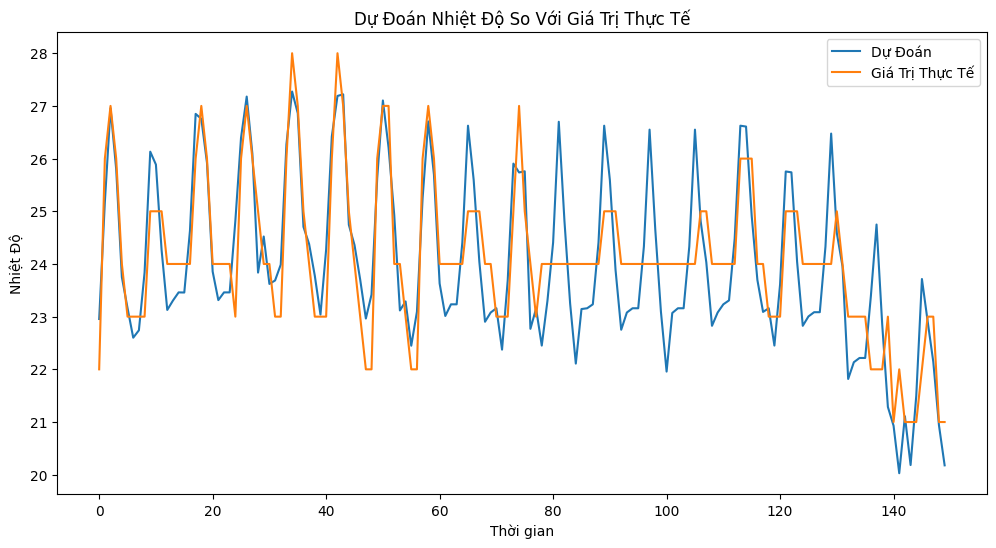

In [189]:
plt.figure(figsize=(12, 6))
plt.plot(y_pred)
plt.plot(data['Temperature'][-150:].to_numpy())

plt.title('Dự Đoán Nhiệt Độ So Với Giá Trị Thực Tế')
plt.xlabel('Thời gian')
plt.ylabel('Nhiệt Độ')
plt.legend(['Dự Đoán', 'Giá Trị Thực Tế'])
plt.show()